Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: Apache-2.0

# Quick Start: Running OpenFold on AWS Batch

## Table of Contents
0. [Install Dependencies](#0.-Install-Dependencies)
1. [Create Target](#1.-Create-Target)
2. [Submit Sequence Alignment and Folding Jobs](#2.-Submit-Sequence-Alignment-and-Folding-Jobs) 
3. [Download results](#3.-Download-results)
4. [Visualze results](#4.-Visualize-results)

## 0. Install Dependencies

In [1]:
# Import required Python packages

import boto3
from datetime import datetime
from batchfold.batchfold_environment import BatchFoldEnvironment
from batchfold.openfold_job import OpenFoldJob
from batchfold.batchfold_target import BatchFoldTarget
from batchfold.mmseqs2_job import MMseqs2Job
import matplotlib.pyplot as plt
from nbhelpers import nbhelpers

# Create AWS clients
boto_session = boto3.session.Session()
batch_environment = BatchFoldEnvironment(boto_session = boto_session)

S3_BUCKET = batch_environment.default_bucket
print(f" S3 bucket name is {S3_BUCKET}")

 S3 bucket name is batchfold-220804-container-1n1e-batchfolds3bucket-5qxhoqyc5dx8


## 1. Create Target

In [2]:
target_id = "7VNA"
target = BatchFoldTarget(target_id=target_id, s3_bucket=S3_BUCKET)
target.add_sequence(
    seq_id=target_id,
    seq="GSIPHKENMFKSKHKLDFSLVSMDQRGKHILGYADAELVNMGGYDLVHYDDLAYVASAHQELLKTGASGMIAYRYQKKDGEWQWLQTSSRLVYKNSKPDFVICTHRQLMDEEGHDLLGKR",
    description="Chain A|Ahr homolog spineless|Drosophila melanogaster",
)

's3://batchfold-220804-container-1n1e-batchfolds3bucket-5qxhoqyc5dx8/7VNA/fastas/7VNA.fasta'

## 2. Submit Sequence Alignment and Folding Jobs

In [3]:
# mmseqs2_job_name = target.target_id + "_MMseqs2Job_" + datetime.now().strftime("%Y%m%d%s")
# mmseqs2_job = MMseqs2Job(
#         job_name = mmseqs2_job_name,
#         target_id = target.target_id,
#         fasta_s3_uri = target.get_fasta_s3_uri(),
#         output_s3_uri = target.get_msas_s3_uri(),
#         boto_session = boto_session,
#         cpu = 64,
#         memory = 500
#     )

openfold_job_name = target.target_id + "_OpenFoldJob_" + datetime.now().strftime("%Y%m%d%s")
openfold_job = OpenFoldJob(
    job_name = openfold_job_name,
    boto_session = boto_session,
    target_id = target.target_id,
    fasta_s3_uri = target.get_fasta_s3_uri(),
    msa_s3_uri = target.get_msas_s3_uri()+"/jackhmmer/",
    output_s3_uri = target.get_predictions_s3_uri() + "/" + openfold_job_name,
    use_precomputed_msas = True,
    config_preset = "finetuning_ptm",
    openfold_checkpoint_path = "openfold_params/finetuning_ptm_2.pt",
    save_outputs = True,
    cpu = 4,
    memory = 15, # Why not 16? ECS needs about 1 GB for container services
    gpu = 1
)

# mmseqs2_submission = batch_environment.submit_job(mmseqs2_job, job_queue_name="GravitonOnDemandJobQueue")
openfold_submission = batch_environment.submit_job(openfold_job, job_queue_name="G4dnJobQueue")#, depends_on=[mmseqs2_submission])

Check on job statuses

In [24]:
# for job in [mmseqs2_job, openfold_job]:
for job in [openfold_job]:
    print(f"Job {job.describe_job()[0]['jobName']} is in status {job.describe_job()[0]['status']}")

Job 7VNA_OpenFoldJob_202208051659732923 is in status SUCCEEDED


## 3. Download Results

Once the jobs are finished, download the results

In [32]:
target = BatchFoldTarget(target_id=target_id, s3_bucket=S3_BUCKET, boto_session=boto_session)
target.download_predictions(local_path="data")

3 files downloaded from s3.
3 files downloaded from s3.
0 files downloaded from s3.
0 files downloaded from s3.


'/Users/bloyal/batch-protein-folding/notebooks/data'

## 4. Visualize Results

### Plot Alignment Data

In [ ]:
plt = nbhelpers.msa_plot(target_id, f"data/{target_id}/msas/mmseqs2")
plt.show()

### Plot Predicted Structure

7VNA_OpenFoldJob_202208051659732923


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

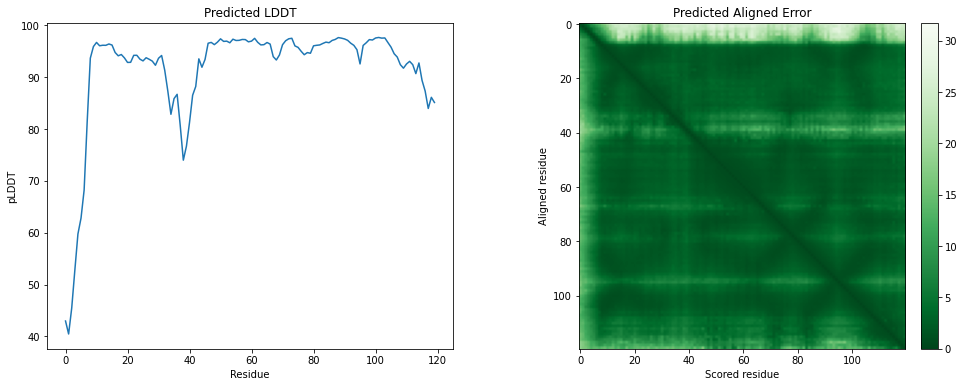

In [33]:
last_job_name = target.list_job_names(job_type="OpenFold")[-1]
print(last_job_name)
nbhelpers.pdb_plot(pdb_path = f"data/{target_id}/predictions/{last_job_name}", show_sidechains=False).show()

## 5. Compare result to experimental structure

Download experimental structure from PDB

In [ ]:
pdb_file = nbhelpers.download_pdb_file(target_id, "data/pdb")

In [ ]:
import py3Dmol

with open(pdb_file) as ifile:
    system = "".join([x for x in ifile])

view = py3Dmol.view(width=800, height=600)
view.addModelsAsFrames(system)
view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
view.show()

### Align OpenFold to experimental structure

In [ ]:
import tmscoring
import py3Dmol

last_openfold_job_name = target.list_job_names(job_type="OpenFold")[0]
print(last_openfold_job_name)
openfold_alignment = tmscoring.TMscoring(
    f"data/{target.target_id}/predictions/{last_job_name}/{target.target_id}_finetuning_ptm_relaxed.pdb",
    f"data/pdb/{target.target_id}.pdb"
    )

# Find the optimal alignment
openfold_alignment.optimise()

# Get the TM score:
tm_score = openfold_alignment.tmscore(**openfold_alignment.get_current_values())
print(f"TM score is {tm_score}")

# Save the aligned files:
openfold_alignment.write(outputfile='openfold_alignment.pdb', appended=True)

with open("openfold_alignment.pdb") as f:
    aligned_pdb = f.read()

view = py3Dmol.view(width=800, height=600)
view.addModels(aligned_pdb)

for n, chain, color in zip(range(2), ["A","B","C",], ["red", "blue", "green"]):
    view.setStyle({"chain": chain}, {"cartoon": {"color": color}}).zoomTo()
view.show()
